In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('bank-additional-full.csv',sep=';')

In [ ]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
data.shape

(41188, 21)

In [ ]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [ ]:
data.y = data.y.map({'yes':1,'no':0})

In [ ]:
data.default = data.default.map({'no':0,'yes':1})
data.housing = data.housing.map({'no':0,'yes':1})
data.loan = data.loan.map({'yes':1,'no':0})
data.contact = data.contact.map({'cellular':1,'telephone':0})

In [ ]:
data.month = data.month.map({'mar':2,'apr':3,'may':4,'jun':5,'jul':6,'aug':7,'sep':8,'oct':9,'nov':10,'dec':11})
data.day_of_week = data.day_of_week.map({'mon':0,'tue':1,'wed':2,'thu':3,'fri':4})

Transforming month and day_of_week by sin function as they are cyclic


In [ ]:
data.month = np.sin(data.month*(2.*np.pi/12))
data.day_of_week = np.sin(data.day_of_week*(2.*np.pi/7))

Encoding categorical variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(handle_unknown='ignore')
OHE.fit(data.job.values.reshape(-1,1))
a_job = OHE.transform(data.job.values.reshape(-1,1)).toarray()

df_job = pd.DataFrame(a_job, columns = ['job_'+str(OHE.categories_[0][i])
                                        for i in range(len(OHE.categories_[0]))])

OHE.fit(data.marital.values.reshape(-1,1))
a_marital = OHE.transform(data.marital.values.reshape(-1,1)).toarray()

df_marital = pd.DataFrame(a_marital, columns = ['marital_'+str(OHE.categories_[0][i])
                                        for i in range(len(OHE.categories_[0]))])

OHE.fit(data.education.values.reshape(-1,1))
a_education = OHE.transform(data.education.values.reshape(-1,1)).toarray()

df_education = pd.DataFrame(a_education, columns = ['education_'+str(OHE.categories_[0][i])
                                        for i in range(len(OHE.categories_[0]))])


OHE.fit(data.poutcome.values.reshape(-1,1))
a_poutcome = OHE.transform(data.poutcome.values.reshape(-1,1)).toarray()

df_poutcome = pd.DataFrame(a_poutcome, columns = ['poutcome_'+str(OHE.categories_[0][i])
                                        for i in range(len(OHE.categories_[0]))])


data = pd.concat([data,df_job,df_marital,df_education,df_poutcome], axis = 1)

data = data.drop(['job','marital','education','poutcome'],axis = 1)

In [ ]:
data.shape

(41188, 44)

In [ ]:
data.dtypes

age                                int64
default                          float64
housing                          float64
loan                             float64
contact                            int64
month                            float64
day_of_week                      float64
duration                           int64
campaign                           int64
pdays                              int64
previous                           int64
emp.var.rate                     float64
cons.price.idx                   float64
cons.conf.idx                    float64
euribor3m                        float64
nr.employed                      float64
y                                  int64
job_admin.                       float64
job_blue-collar                  float64
job_entrepreneur                 float64
job_housemaid                    float64
job_management                   float64
job_retired                      float64
job_self-employed                float64
job_services    

Train Test Split:

In [ ]:
data_y = data.pop('y')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,data_y,test_size = 0.2,random_state = 19)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 19)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape,y_val.shape)

(32950, 43) (32950,)
(4119, 43) (4119,)
(4119, 43) (4119,)


Filling Mising values:

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=150, random_state=0)
imp.fit(X_train.values)
X_train_imp = imp.transform(X_train.values)
X_test_imp = imp.transform(X_test.values)
X_val_imp = imp.transform(X_val.values)

X_train = pd.DataFrame(data=X_train_imp, columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(data=X_test_imp, columns = X_test.columns, index = X_test.index)
X_val = pd.DataFrame(data=X_val_imp, columns = X_val.columns, index = X_val.index)

Heat map to show correlation between features:

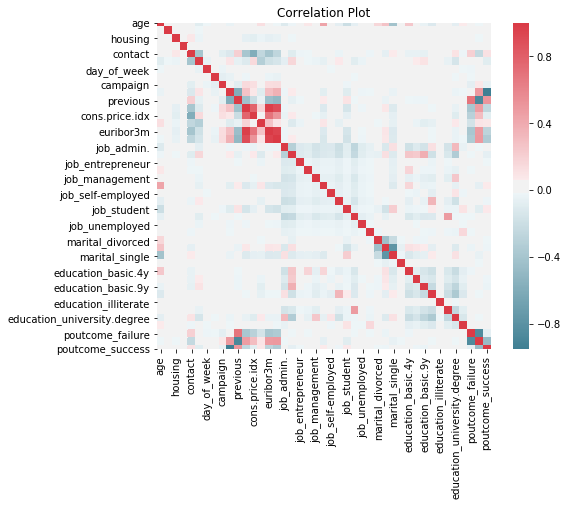

In [ ]:
corr_df=X_train  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Plots of all features:

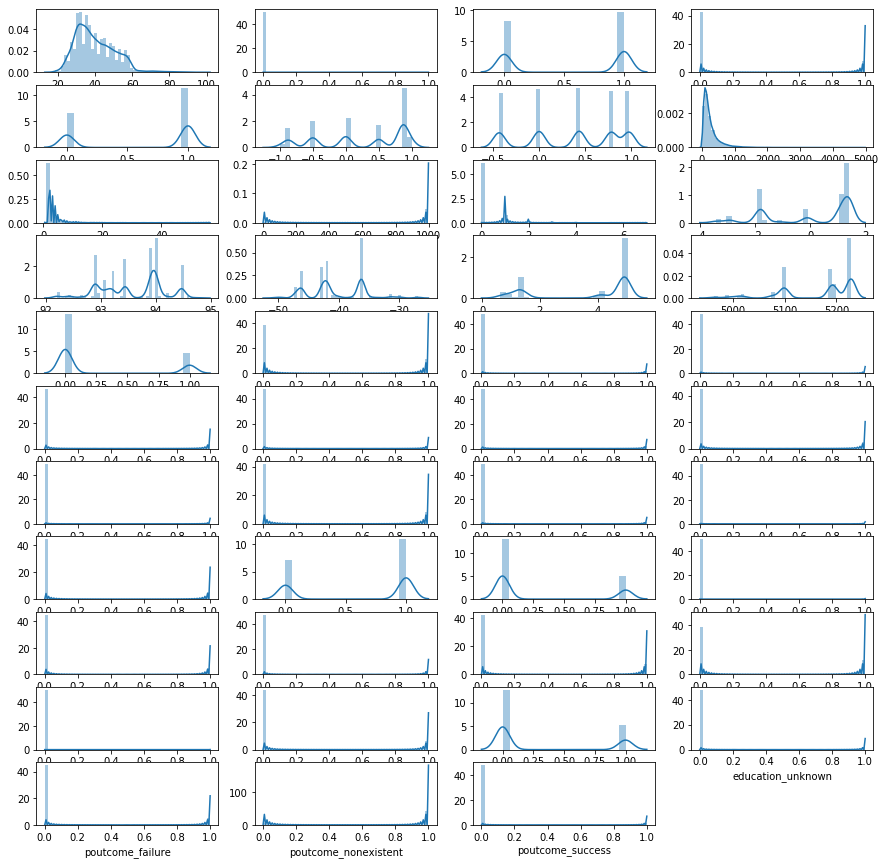

In [ ]:
fig = plt.figure(figsize=(15,15))
for i, col in enumerate(data.columns): 

    ax = fig.add_subplot(11, 4, i+1)
    sns.distplot(data[col].dropna())

Box Cox Transformation:

In [ ]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson', standardize=False)
power.fit(X_train)
X_t = power.transform(X_train)
X_v = power.transform(X_val)
X_train = pd.DataFrame(data=X_t, index=X_train.index, columns=X_train.columns)
X_val = pd.DataFrame(data=X_v, index=X_val.index, columns=X_val.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:2828: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [ ]:
X_train.head()

,age,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,poutcome_failure,poutcome_nonexistent,poutcome_success
22581,0.050995,-0.139295,-1.092309,-0.459431,0.756235,-1.125664,-1.483013,-0.506087,1.189887,0.194746,-0.397248,0.941684,-0.278891,0.970027,0.808079,0.988888,1.716974,-0.539437,-0.189652,-0.160849,-0.275788,-0.209786,-0.193146,-0.325066,-0.147757,-0.441991,-0.157542,-0.089700,-0.354036,0.81011,-0.628165,-0.043768,-0.33367,-0.243127,-0.416854,-0.549836,-0.020617,-0.380438,1.543908,-0.207886,-0.339259,0.397248,-0.184965
36682,1.080509,-0.139295,-1.092309,-0.459431,0.756235,0.287964,-1.483013,1.521630,-1.044531,0.194746,-0.397248,-1.532187,-1.055545,-0.005804,-1.373791,-1.343516,-0.582420,-0.539437,-0.189652,-0.160849,-0.275788,-0.209786,-0.193146,-0.325066,-0.147757,2.262487,-0.157542,-0.089700,-0.354036,-1.23440,1.591939,-0.043768,-0.33367,-0.243127,-0.416854,-0.549836,-0.020617,-0.380438,1.543908,-0.207886,-0.339259,0.397248,-0.184965
7590,0.772819,0.539458,-1.092309,-0.459431,-1.322340,0.992851,-1.483013,-0.247739,-1.044531,0.194746,-0.397248,0.565426,0.705650,0.911314,0.722850,0.144015,-0.582420,-0.539437,-0.189652,-0.160849,-0.275788,-0.209786,-0.193146,-0.325066,-0.147757,-0.441991,-0.157542,11.148326,-0.354036,0.81011,-0.628165,-0.043768,-0.33367,-0.243127,-0.416854,-0.549836,-0.020617,-0.380438,-0.647707,4.810322,-0.339259,0.397248,-0.184965
35961,1.737546,-0.139295,-1.092309,-0.459431,0.756235,0.992851,-0.762170,0.643232,-1.044531,0.194746,-0.397248,-1.241306,-1.162453,-1.275035,-1.375079,-1.143598,-0.582420,-0.539437,-0.189652,-0.160849,-0.275788,4.766771,-0.193146,-0.325066,-0.147757,-0.441991,-0.157542,-0.089700,-0.354036,0.81011,-0.628165,-0.043768,-0.33367,-0.243127,2.398920,-0.549836,-0.020617,-0.380438,-0.647707,-0.207886,-0.339259,0.397248,-0.184965
27665,1.360501,-0.139295,-1.092309,-0.459431,0.756235,-1.497430,-1.483013,0.025617,0.247966,0.194746,2.516407,-0.529355,-0.682221,-0.274154,0.062441,0.240117,-0.582420,-0.539437,-0.189652,-0.160849,3.625976,-0.209786,-0.193146,-0.325066,-0.147757,-0.441991,-0.157542,-0.089700,-0.354036,0.81011,-0.628165,-0.043768,-0.33367,-0.243127,2.398920,-0.549836,-0.020617,-0.380438,-0.647707,-0.207886,2.947597,-2.517319,-0.184965


Standard Scaling on all features:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_t = scaler.transform(X_train)
X_v = scaler.transform(X_val)
X_train = pd.DataFrame(data=X_t, index=X_train.index, columns=X_train.columns)
X_val = pd.DataFrame(data=X_v, index=X_val.index, columns=X_val.columns)


**MODELS:**

Logistic Regression:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
log = LogisticRegression()
log.fit(X_train,y_train)
y_train_pred = log.predict(X_train)
y_val_pred = log.predict(X_val)
print(f1_score(y_train,y_train_pred))
print(f1_score(y_val,y_val_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5244778067885116
0.48364153627311524


LogisticRegressionCV:

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score
LR = LogisticRegressionCV(cv=5,  max_iter=400)
LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=400, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [ ]:
y_train_pred = LR.predict(X_train)
y_val_pred = LR.predict(X_val)
print(f1_score(y_train,y_train_pred))
print(f1_score(y_val,y_val_pred))

0.5257664709719505
0.48364153627311524


XGBoost


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=2, learning_rate=0.06, n_estimators=2000, subsample=0.5, colsample_bytree=0.35, gamma=1, min_child_weight=12)
xgb.fit(X_train,y_train)
y_train_pred = xgb.predict(X_train)
y_val_pred = xgb.predict(X_val)
print(f1_score(y_train,y_train_pred))
print(f1_score(y_val,y_val_pred))

0.6327700663850332
0.5803108808290156


Randomized Search to find best parameters for XGBoost:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'learning_rate': [0.03, 0.06, 0.08],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.3, 0.6],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
from sklearn.metrics import make_scorer        

In [ ]:
xgb = XGBClassifier(n_estimators=800,
                    silent=True, nthread=1)

In [ ]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=3, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=3, random_state=2 )

In [ ]:
# redo for transformed and scaled data - was taking too much time
random_search.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=800,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           re...
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=3, 

In [ ]:
print(random_search.best_params_)

{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 5, 'colsample_bytree': 0.8}


XGBoost with best parameters:

In [ ]:
#xgboost with best params
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=4, learning_rate=0.03, n_estimators=2000, subsample=0.6, colsample_bytree=0.8, gamma=5, min_child_weight=1)
xgb.fit(X_train,y_train)
y_train_pred = xgb.predict(X_train)
y_val_pred = xgb.predict(X_val)
print(f1_score(y_train,y_train_pred))
print(f1_score(y_val,y_val_pred))

0.6851038923031899
0.5984848484848485


SVC

In [ ]:
from sklearn.svm import SVC
svc = SVC(C=0.3, class_weight='balanced', degree=6, probability=True)
svc.fit(X_train, y_train)

SVC(C=0.3, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=6, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_train_pred = svc.predict(X_train)
y_val_pred = svc.predict(X_val)
print(f1_score(y_train,y_train_pred))
print(f1_score(y_val,y_val_pred))

0.5752701476532212
0.5525946704067322


Randomized Search for SVC params:

In [ ]:
params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma' : [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
        }

In [ ]:
random_svc = RandomizedSearchCV(xgb, param_distributions=params, n_iter=3, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=2, random_state=2 )

In [ ]:
# redo - was taking too much time
random_svc.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 16.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8, gamma=1.5,
                                           learning_rate=0.03, max_delta_step=0,
                                           max_depth=5, min_child_weight=10,
                                           missing=None, n_estimators=2000,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None,
                                           subsample=0.6, verbosity=1),
 

In [ ]:
random_svc.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
svc = SVC(C=1,gamma=0.001, kernel='rbf' ,class_weight='balanced', degree=6, probability=True)
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_val_pred = svc.predict(X_val)
print(f1_score(y_train,y_train_pred))
print(f1_score(y_val,y_val_pred))

0.5548654244306418
0.5524079320113314


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=5)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_train_pred = rfc.predict(X_train)
y_val_pred = rfc.predict(X_val)
print(f1_score(y_train,y_train_pred))
print(f1_score(y_val,y_val_pred))

0.32241490044958254
0.2867924528301886


Randomized search on fandom forest classifer:

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2' ],
    'max_depth' : [2,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
random_rfc = RandomizedSearchCV(rfc, param_distributions=param_grid, n_iter=3, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=3, random_state=2 )

In [ ]:
random_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=5,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=500,
                                                    n_jobs=None,
    

In [ ]:
random_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

Random forest with best params:

In [ ]:
rfc = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=8, max_features='auto',criterion='entropy')
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_val_pred = rfc.predict(X_val)
print(f1_score(y_train,y_train_pred))
print(f1_score(y_val,y_val_pred))

0.4511837213852475
0.33743409490333914


Best Result observed with XGBoost